# Formula 1 Modelling Regression


Author : Ben Palmer\
Date : 02/11/2022

# Summary:
Is this notebook we have:

- Built a range of regression models to predict the results for Qualifying Position and Lap Time Delta:
    - Linear Regression
    - Random Forest
    - XG Boost
    - Neural Network
- Optimised the hyper parameters for Random Forest and XGBoost
- Evaluated the performance of the models and selected the best models:
    - Random Forest for Qualifying Position
    - XGBoost for Lap Time Delta
- Evaluated the importance features for each prediction and found:
    - Position prediction is heavily linked to the top teams, with some interesting features in variance of RPM of the engine
    - Lap time delta uses more features related to the car telemetry, and is affected by distance on brakes, sector times, cornering speed and RPM of the engine.

# Introduction:
The aim of this notebook is the evaulate the performance of regression models on predicting
- Qualifying Position
- Laptime Delta 

Optimise the models, selec the best and evluate the predictive power of these models.

# Table of Contents:
1. [Prepare data for Modelling](#prep)
   
2. [Baseline Linear Regression](#linear)

3. [Random Forest](#initialRF)\
    3.1 [Manual Features](#RFmanual)\
    3.2 [Automatic Features](#RFauto)\
    3.3 [Optimise for lap time delta](#lapdeltaRF)\
    3.4 [Optimise for Position](#posRF)

4. [XG Boost](#xgboost)\
    4.1 [Vanilla XG Boost](#xgintial)\
    4.2 [Optimise for lap time delta](#lapdeltaXG)\
    4.3 [Optimise for Position](#posXG)

5. [Neural Network](#nn)\
    5.1 [lap time delta](#lapdeltann)\
    5.2 [position prediction](#posnn)

6. [Summary](#summary)\
    6.1 [Feature Importance](#feature)\
    6.2 [Summary](#summary2)\
    6.2 [Next Steps](#nextsteps)

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats

from scripts.ds_ultils import *
from scripts.fastf1_data_download import *
from scripts.model_ultils import *

plt.style.use('./scripts/plotstyle.mplstyle')
import warnings

warnings.filterwarnings('ignore')
import joblib
import shap
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from mlxtend.feature_selection import ColumnSelector
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_roc_curve, r2_score,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                   StandardScaler)
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.metrics import MeanAbsoluteError
from keras.models import Sequential
from xgboost import XGBRegressor


## Prepare data for Modelling
<a id="prep"></a>

The data needs to be prepared before any predictions can be made. This is to ensure there are no NaN values (when driving data is not recorded), the columns are in the right format and the final target and feature engineering is complete. 
The prepare modelling function does all of this, it:
- converts columns which are numeric to float
- Creates the target features and bins
- Creates the home country feature
- Cleans the dataframe 
- Fixes the GrandPrix where the DRS telemetry data was not working. 

The raceids for test set where defined by a random selection of two races for each year, to keep the test set consitent with previous modelling techniques the raceIds are passed into the function. Another option will be to use a random train test split by Sklearn library, however this will select random driver results from lots of different grandprix's and this does not reflect reality as the model will learn something about every GrandPrix in every year. Whereas in reality, the model will recieve data for a whole GrandPrix in a year which it hasn't been trained on. Therefore it makes most sense to split the test by the results of whole GrandPrix's and not completely randomly. 

This then also completes the test train split.


In [14]:
qualify_df=pd.read_pickle('./data/model_data/formula1_complete_2018_2022_complete_301022.pkl',compression='gzip')
qualifying_df=qualify_df.copy()
qualifying_df.dropna(inplace=True)
raceids=[989, 1010, 990, 1036, 1041, 1084, 1061, 1026, 1073, 1088]
X_test, X_train, y_test, y_train = prepare_modelling_df(qualifying_df,test_raceids=raceids)
ypos_train=y_train['quali_position'].copy()
ypos_test=y_test['quali_position'].copy()
ydelta_train=abs(y_train['lap_timedelta_milliseconds'].copy())
ydelta_test=abs(y_test['lap_timedelta_milliseconds'].copy())


Lets initiate a empty list to save the results of the models during the model investigation process.

In [7]:
Results_summary=[]

## Linear Regression Baseline on manual features
<a id="linear"></a>

Intially lets see how a linear regression baseline model performs. The notebook [6_Formula1_Initial_Modelling](./6_Formula1_Initial_Modelling.ipynb), investigated which are the most important features and shows that manual feature selection performs the best.Therefore for regression we will subset the features using the most important features. Similar to previous analysis the Sector Times of Fastest Lap are removed since these are just the break down of the times of the target and therefore not considered an input feature.

The function below, apply the manual features to the X features and saves the column names for the numerical columns which need to be scaled and the categorical columns which need to be hot encoded.

In [15]:
feature_importance=pd.read_pickle('./data/model_data/feature_importance_random_forest.pkl')
manual_features = list(feature_importance[feature_importance['Random_forest_result']>0.0105].index)
features_remove =[ 'numerical_transform__fastestlap_Sector1',
 'numerical_transform__fastestlap_Sector2',
 'numerical_transform__fastestlap_Sector3', 
 ] 
manual_features = [x for x in manual_features if x not in features_remove]
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

Initiate the Linear regression pipeline, which is a column transformer and Linearregression model

In [5]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
linear_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('linear_regression',LinearRegression())# classifier
        
]
linear_pipe=Pipeline(linear_estimator)

How does a Linear model preform with no parameter tuning?

In [6]:
linear_pos= linear_pipe.fit(X_train_manual,ypos_train)
pos_predictions=linear_pos.predict(X_test_manual)
print(f'Position Linear regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Linear regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

linear_delta= linear_pipe.fit(X_train_manual,ydelta_train)
delta_predictions=linear_delta.predict(X_test_manual)
print(f'Lap Delta Linear regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Linear regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')



Position Linear regression Initial R2 score with manual selected featuers 0.4686308011801288
Position Linear regression Initial MAE score with manual selected feaure 2.9908472177933674
Lap Delta Linear regression Initial R2 score with manual selected featuers -0.26117657260662064
Lap Delta Linear regression Initial MAE score with manual selected feaure 898.9311224489796


Linear model performed reasonably well straight out of the box for position. The Mean Absolute Error for a simple linear model is 3 which is less than the bin size of the classification models. Therefore this indicates a Regression model may be worth investigating further. The linear model on lap time delta did not perform as well especially with R2. However the mean absolute error is the same as the bin size of the classification model. If a simple linear regression model has the same error as the bin size of the classification model, this can explain why the classification model got confused in the middle of the pack and would assign drivers into the wrong neighboring class because the bins are likely too coarse. 

How are the residuals? Are they homescedastic?

The purpose to check is to see if there is a pattern in the residuals or not. If there is it would suggest there is some pattern in the data the model is not picking up on and therefore would struggle in reality. 

To do this we will calculate the residuals of the test set.

The homoscedasticity test function, generates a Q-Q plot to see visualy if the residuls are normally distributed. Then it runs a shaprio wilk test to check the statiscal significance of normailty of the residuals.

In [14]:
#residuals
pos_test_resid=ypos_test-pos_predictions
delta_test_resid=ydelta_test-delta_predictions

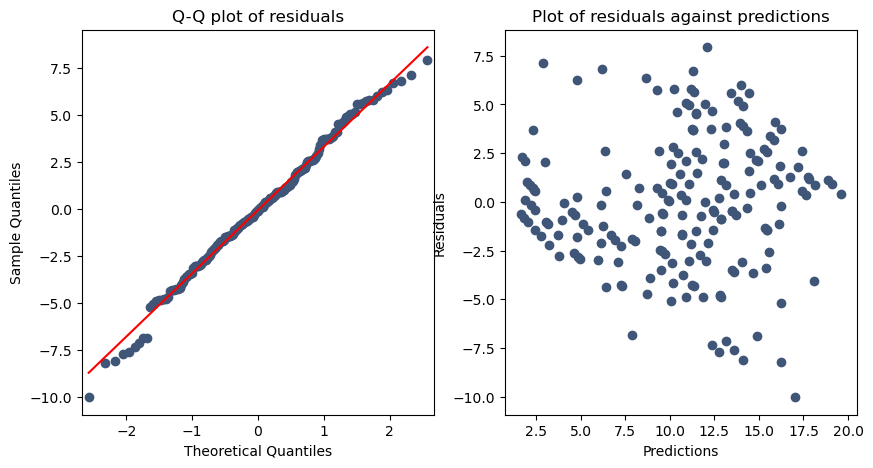

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9929277896881104, pvalue=0.4670012593269348)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


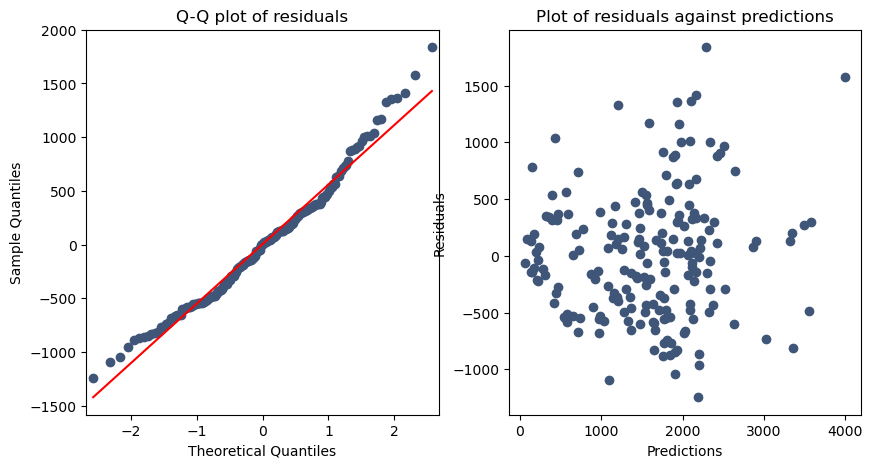

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9786797761917114, pvalue=0.004407133441418409)
can reject null hypothesis and residuals may not be normally distributed
---------------------------


In [38]:
homoscedasticity_test(pos_test_resid,pos_predictions)
homoscedasticity_test(delta_test_resid,delta_predictions)

From the Q-Q plot and the shaprio wilk tests, we can see the residuals for the position model are likely normally distributed where as they are not for the Lap time delta. they show a slight tendacy to spread out for higher delta time predictions. Therefore indicating the model is missing something related to the data.

We can see how the Predictions compare to the True values by plotting the Predictions vs True on a simple scatter plot. A perfect model where predictions=True the points will all be down the red (y=x) line. Where model over predicts the points  will be above the line and under predicts beneath the line.

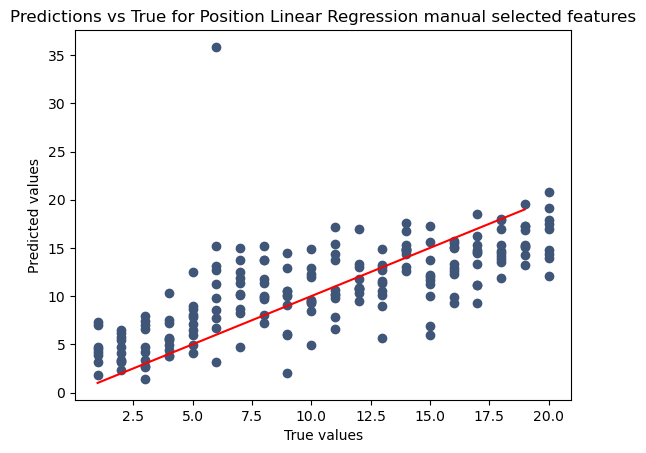

In [7]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Linear Regression manual selected features')
plt.show()

For position we can see a simple Linear regression model does reasonably well in capturing the main trend. Predicting bottom drivers at the back and top drivers towards the front correctly. There is only one outlier value. The model does "average" out the results slighty, predicting worse than true values for top drivers and slightly better than true values for the bottom drivers.

How does lap time delta fair?

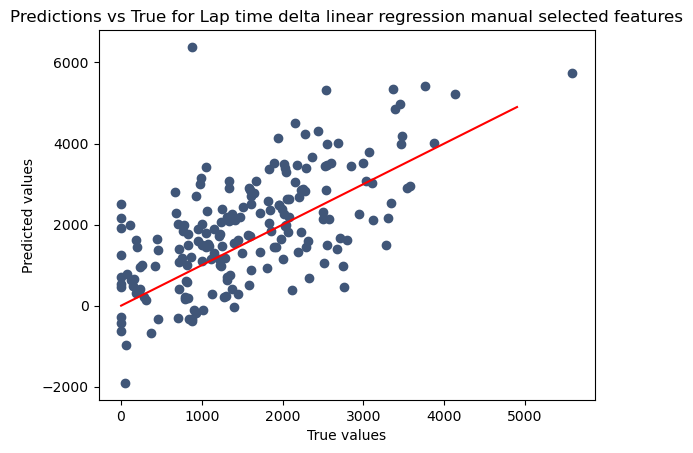

In [8]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta linear regression manual selected features')
plt.show()

Similar to position prediction we can see a linear regression model captures the main trend, predicting correctly the trend, captuing top drivers to be closer to 0 and worse drivers having higher lap time deltas. There are couple of outliers which affect the R2, plus the model predicts negative lap time deltas which is impossible as drivers can't be in front of the fastest driver at that circuit. 

For both Position and Lap time delta predictions there is enough evidence suggest that a regression model could be worth investigating further, this is because the MAE is beneath the previous classification bin size. Plus a very simple linear model is able to capture the trend well to predict roughly the correct order of drivers.

We will continue the investigation to see if we can improve the model further.

First save the results of the linear model to a dataframe and into the empty results summary list

In [41]:
Results_summary.append(pd.DataFrame({'Model':'LinearRegression',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))
Results_summary.append(pd.DataFrame({'Model':'LinearRegression',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'no'},index=[0]))

In [ ]:
print(pd.concat(Results_summary).to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no

## Random Forest Regression
<a id="initialRF"></a>

The next model we will try is a Random Forest. This is because as an ensemble of Decision Trees it will be able to capture the predictive power of the input features without overfitting the training data. As it is is an ensemble of lots of simple trees (which on their own are rather stupid) it uses the collective power of many trees to predict and thereby avoids the issues of a single large tree learning the training set well but doing poorly on a test set.

## Random Forest with manual features selected
<a id="RFmanual"></a>

To start with we will test a simple vanilla random forest with the manual features from our previous analysis. First establish the pipeline, similar to Linear regression replacing just the classifer

In [47]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('random_forest',RandomForestRegressor())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [48]:
forest_pos= forest_pipe.fit(X_train_manual,ypos_train)
pos_predictions=forest_pos.predict(X_test_manual)
print(f'Position Random Forest regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')
forest_delta= forest_pipe.fit(X_train_manual,ydelta_train)
delta_predictions=forest_delta.predict(X_test_manual)
print(f'Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Position Random Forest regression Initial R2 score with manual selected featuers 0.6544647434699569
Position Random Forest regression Initial MAE score with manual selected feaure 2.6456632653061223
Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.6890606956197174
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 433.31295918367346


Out of the box Random forest makes a big improvement on Linear Regression, the MAE for position drops to 2.6 and even more impressive for lap time delta down to 400 milliseconds or 0.4s. The Random Forest has greatly improved the model over Linear Regression. 
The R2 has jumped up from negative values to 0.69 for Lap time delta. 

Lets save this models in case we need them later.

In [5]:
joblib.dump(forest_delta,'./pickled_random_forest_initial_lapelta_model.pkl',compress=('gzip',3))
joblib.dump(forest_pos,'./pickled_random_forest_initial_position_model.pkl',compress=('gzip',3))

['./pickled_random_forest_initial_position_model.pkl']

How are the residuals? Are they normally distributed?

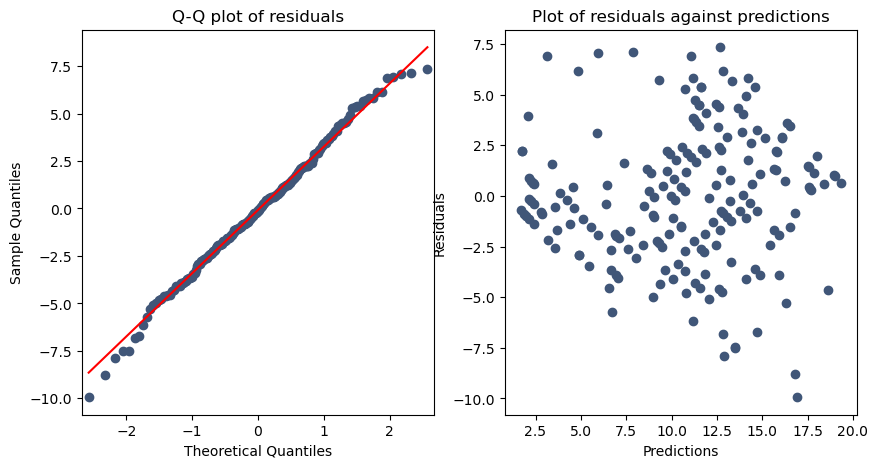

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9941951632499695, pvalue=0.6447181701660156)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


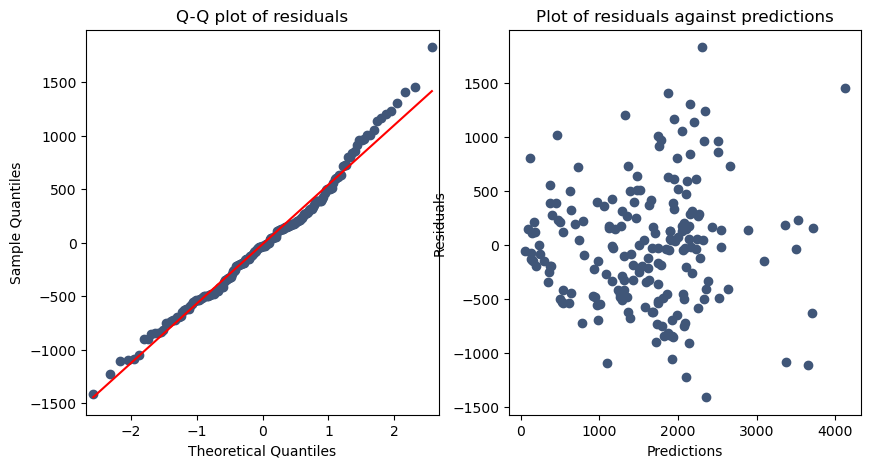

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9863252639770508, pvalue=0.054977815598249435)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


In [49]:
#residuals
pos_test_resid=ypos_test-pos_predictions
delta_test_resid=ydelta_test-delta_predictions
homoscedasticity_test(pos_test_resid,pos_predictions)
homoscedasticity_test(delta_test_resid,delta_predictions)

Both Position and Lap time delta models have normally distributed residuals, this is shows the models are likely capturing all the variance of the data. However, the lap time delta residuals from the Q-Q plot and Shaprio Wilk result are only marginally normally, so the model is still struggling more to predict Lap Time delta.

How do these models compare to the predicted values ?

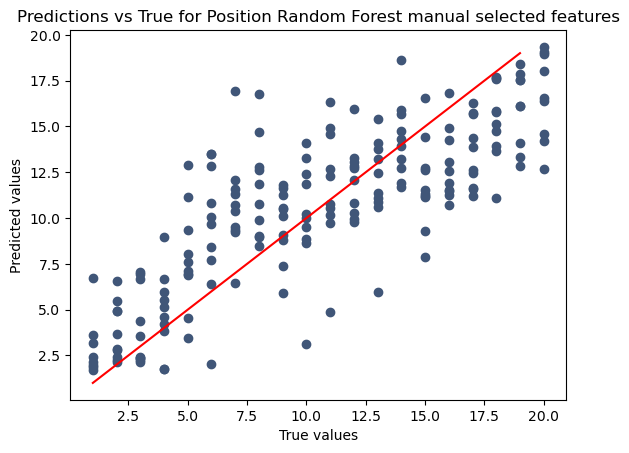

In [50]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Random Forest manual selected features')
plt.show()

Overal the model is doing well for position, it has captured the main trend and removed the anomalous points. Overall it predicts the drivers less than 10 to do worse and the back 10 drivers to do better. It is averaging out there results. This may be because it has the complete freedom to predict any value and therefore with similar input values it does not get "confident" to predict the ranked integers from 1 to 20

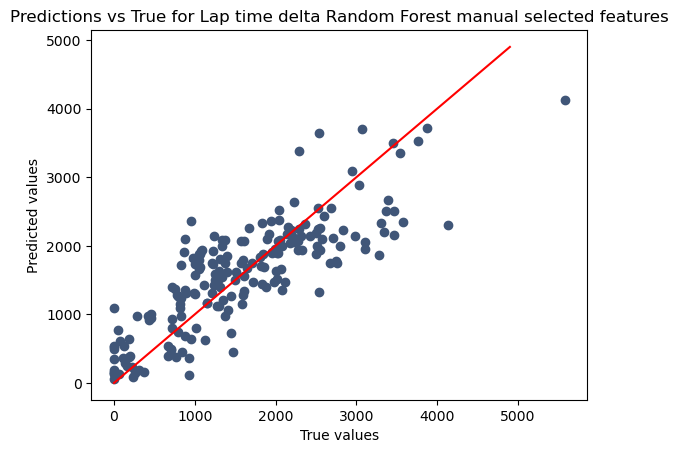

In [51]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Random Forest manual selected features')
plt.show()

There is a marked improvement in the the plot of prediction vs true for lap time delta. The RF model does not predict any negative lap time deltas, it had strong cluster of points near the red line where predictions=true.

There is a slight spread of data points at the higher lap times which may contribute to the reisduals being marginally normally distrubuted. THis is likely caused by a lack of data points at the higher lap time delta values.

Lets save the results:

In [52]:
Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))
Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'yes'},index=[0]))

In [ ]:
print(pd.concat(Results_summary).to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |

## Random Forest Automatic Select Features 
<a id="RFauto"></a>

As shown in the classification model prediction in [6_Formula1_Initial_Modelling](./6_Formula1_Initial_Modelling.ipynb) the models performed equally well when manually selecting the best features or using automatic feature selection. This shows that we have got the best features in the manual selection. 

However is this still true for regression?

We will run a RF model with automatic feature selection to compare. 

Build the pipeline, including Select from Model RandomForest Regressor, with max features equal to 70, which is the same number of features as manual features. To use max features, threshold has to be minus infinity

In addittion the X and y datasets which where generated before manual feature selection were used.

In [53]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('select_from_model',SelectFromModel(RandomForestRegressor(),threshold=-np.inf,max_features=70)),
        ('random_forest',RandomForestRegressor())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [54]:
forest_pos= forest_pipe.fit(X_train,ypos_train)
pos_predictions=forest_pos.predict(X_test)
print(f'Position Random Forest regression Initial R2 score with auto selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MAE score with auto selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')
forest_delta= forest_pipe.fit(X_train,ydelta_train)
delta_predictions=forest_delta.predict(X_test)
print(f'Lap Delta Random Forest regression Initial R2 score with auto selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with auto selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Position Random Forest regression Initial R2 score with auto selected featuers 0.6496559715443899
Position Random Forest regression Initial MAE score with auto selected feaure 2.6768367346938775
Lap Delta Random Forest regression Initial R2 score with auto selected featuers 0.6813218350377463
Lap Delta Random Forest regression Initial MAE score with auto selected feaure 441.06704081632654


The initial scores are very similar to manual feature selection, no change indicating that the model uses the same features as where manaully selected. 

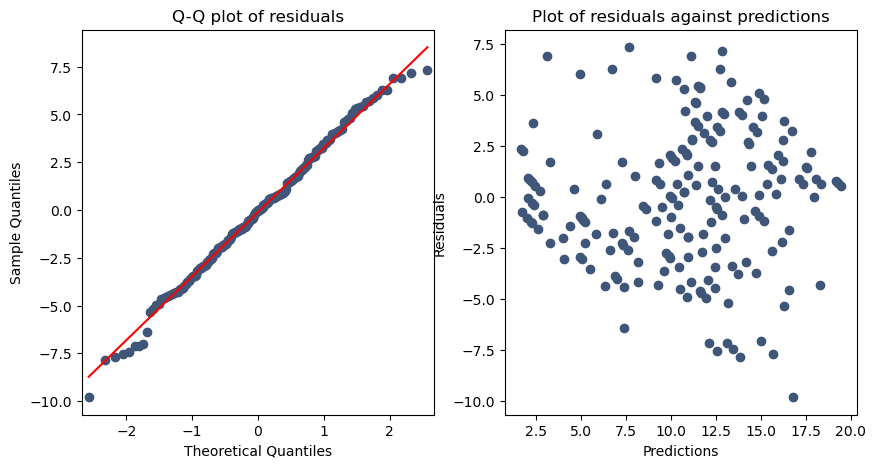

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9936692118644714, pvalue=0.5681770443916321)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


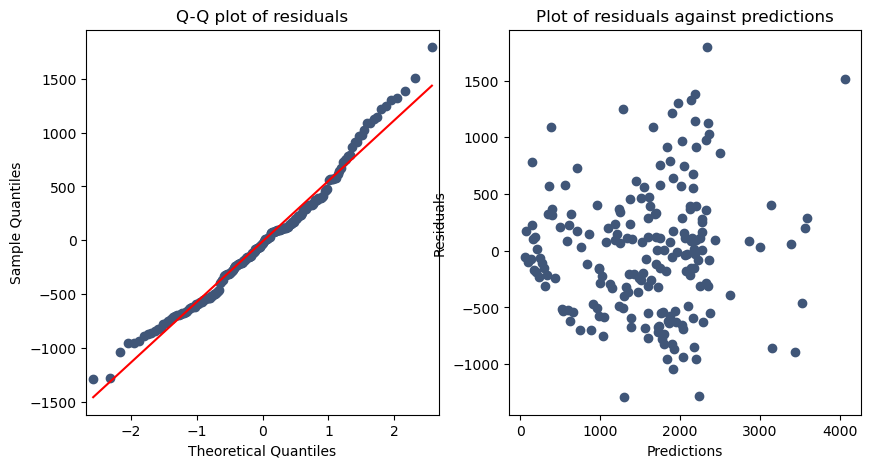

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9806280732154846, pvalue=0.008222158998250961)
can reject null hypothesis and residuals may not be normally distributed
---------------------------


In [55]:
#residuals
pos_test_resid=ypos_test-pos_predictions
delta_test_resid=ydelta_test-delta_predictions
homoscedasticity_test(pos_test_resid,pos_predictions)
homoscedasticity_test(delta_test_resid,delta_predictions)

The plots of residuals look very similar to Random Forest with manual feature selection. Except that the lap time delta residuals are worse. This may indicate that one of the features missing from manual feature selection which has important predictive power is left in the residuals. This would indicate that the manual features used are the best features for predicting the results by regression.

How do the results look like against the true values?

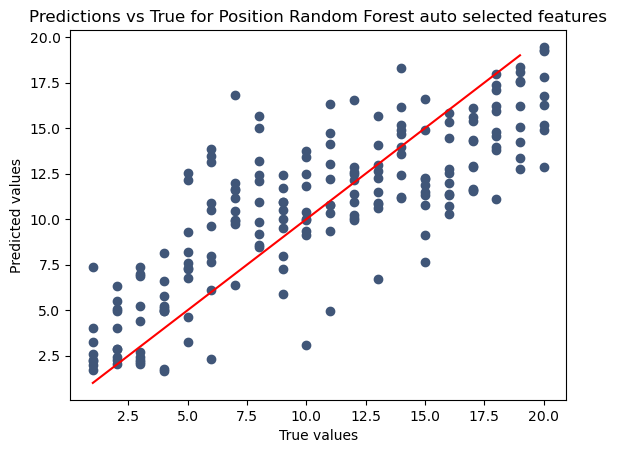

In [57]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Random Forest auto selected features')
plt.show()

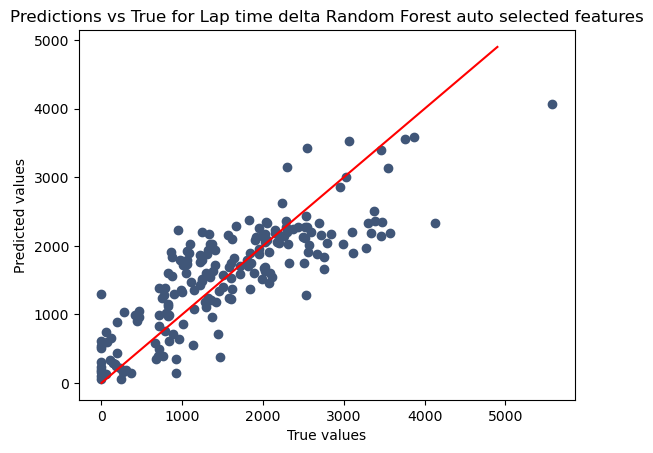

In [58]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Random Forest auto selected features')
plt.show()

As we can see from the plots of True versus prediction. The values are mostly similar. In addition for lap time delta we can see that the model does worse for the drivers with larger lap time deltas. It starts to under predict the results, this confirms what was seen in the residuals and supports the hypothesis that there is feature missing in manual feature selection which captures the worse drivers well. 

**For the rest of the analysis we will use manual feature selection as it performs better than automatic feature selection**

Save the results:

In [59]:
Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest Auto Features',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))

Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest Auto Features',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'no'},index=[0]))

In [ ]:
print(pd.concat(Results_summary).to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |
|  4 | Initial RandomForest Auto Features | Position | 0.649656 |     11.2736 |   2.67684 | yes                |
|  5 | Initial RandomForest Auto Features | LapDelta | 0.681322 | 317470      | 441.067   | no                 |


## Optimise Lap time delta values manual features
<a id="lapdeltaRF"></a>

Now we have seen that so far Random Forest with manaul feature selection has performed the best. Can we tune the models hyperparameters to improve the model?

First we will try to optimise lap time delta.

First re initate the pipeline:

In [110]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('random_forest',RandomForestRegressor())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

What are the initial default parameters of Random Forest. Lets print the initial parameters:

In [111]:
forest_pipe['random_forest'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

As we can see there are number of hyperparameters we can vary. We will select a range that we expect to have the biggest impact and search for the optimal parameters of those:
- Number of estimators, this can have a large impact as controls the number of simple trees in the model
- Criterion, this is the criterion to rank the information gain at the splits
- Max depth, how deep are the trees, the deeper the trees the more they learn but can also overfit
- Min samples leaf, how isolating can leaf become? This stops leafs only having 1 sample and reducing overfitting
- Max features, number of features used to build each tree.

First we will apply a large randomised search to then narrow down with a grid search to find the final optimum parameters. Randomised search applies cross validation by splitting the dataset into chunks and rotating the validation set, hence making sure we are not affected by the split of our train test split

Lets take the number of estimators from a small number 10, to 5 times the default value of 100 which we know did well.
We can try all the criterion.\
For max depth, we can keep it open for know, but knowing the more simple trees are what we are aiming for.\
Minimum samples take an arbitary large range of 1 to 50\
Max features from 10 to the number of features in the dataset ~60.

We will use a randomised search of 100 to try lots of different combinations so that we are confident we have narrowed down the parameter space to test further in grid search. This approach is to true reduce run time as running a open grid search will take a long time.

In [112]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(10,500,10),
    'random_forest__criterion':['squared_error', 'absolute_error', 'poisson'],
    'random_forest__max_depth':np.arange(5,100,10),
    'random_forest__min_samples_leaf': np.arange(1,50,5),
    'random_forest__max_features':np.arange(10,60,10)
   
    }
   
]

grid_rf = RandomizedSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1, n_iter=100,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'random_forest__n_estimators': 380, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 20, 'random_forest__max_depth': 75, 'random_forest__criterion': 'poisson'}


Running the randomised search has shown that increasing the number of estimators and the depth of the trees has improved the validation score. Inaddition we have seen an improvement with using 20 features. We can use this learning to refine a Grid Search. The difference between Randomised and Grid Search is that Grid Search tests every possible combination in a cross validation whereas random search only takes random selections from the parameter grid.

We will look to optimise the number of estimators, max depth and features further in Grid Search

In [113]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(350,400,10),
    'random_forest__criterion':['poisson'],
    'random_forest__max_depth':np.arange(60,90,5),
    'random_forest__min_samples_leaf': [1],
    'random_forest__max_features':np.arange(10,30,5),    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'random_forest__criterion': 'poisson', 'random_forest__max_depth': 85, 'random_forest__max_features': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 380}


Here we have the final optimised hyperparameters from the Grid Search

In [114]:
print(fittedgrid_rf.best_params_)

{'random_forest__criterion': 'poisson', 'random_forest__max_depth': 85, 'random_forest__max_features': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 380}


We can save the results of the grid search to inspect the best combination

In [115]:
results_rf_pos = pd.DataFrame({'Validation score':fittedgrid_rf.cv_results_['mean_test_score'],
'Train score':fittedgrid_rf.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_rf.cv_results_['param_random_forest__n_estimators'],
'max_depth_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_depth'],
'max_features_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_features'],
'min_samples_leaf_in_grid': fittedgrid_rf.cv_results_['param_random_forest__min_samples_leaf']})
results_rf_pos

,Validation score,Train score,n_estimators_in_grid,max_depth_in_grid,max_features_in_grid,min_samples_leaf_in_grid
0,0.452572,0.949167,350,60,10,1
1,0.474527,0.954430,360,60,10,1
2,0.489542,0.948855,370,60,10,1
3,0.498000,0.951501,380,60,10,1
4,0.488108,0.950908,390,60,10,1
...,...,...,...,...,...,...
115,0.478284,0.949646,350,85,25,1
116,0.466982,0.950326,360,85,25,1
117,0.492104,0.949296,370,85,25,1
118,0.472792,0.951978,380,85,25,1


Here we can see that the validation scores did not vary much as we where focused on a narrow set of parameters. Also we can see the difference between Train and Validation showing that the model is starting to over train.

In [116]:
print('Best Random Forest lap delta regression model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test_manual, ydelta_test))

Best Random Forest lap delta regression model accuracy_score on X test: 0.69600260207725


We can see that the R2 square score has been improved by hyper-parameter optimisiation.

lets save the model:

In [117]:
joblib.dump(fittedgrid_rf.best_estimator_, 'pickled_best_RF_regression_model_lapdelta.pkl')

['pickled_best_RF_regression_model_lapdelta.pkl']

Lets evaluate this optimised model further by running the results of R2, MSE, MAE and testing the residuals and plots of true veruss predictions:

In [118]:
RF_best_lapdelta_model = joblib.load('pickled_best_RF_regression_model_lapdelta.pkl')

In [119]:
delta_predictions=RF_best_lapdelta_model.predict(X_test_manual)
print(f'Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.69600260207725
Lap Delta Random Forest regression Initial MSE score with manual selected feaure 302845.31206437247
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 433.69212082399224


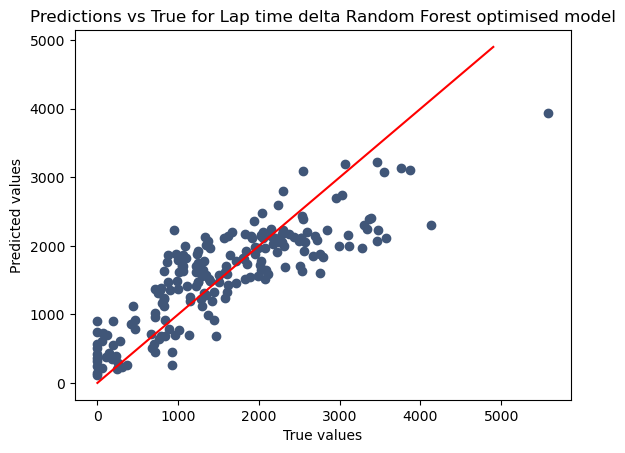

In [120]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Random Forest optimised model')
plt.show()

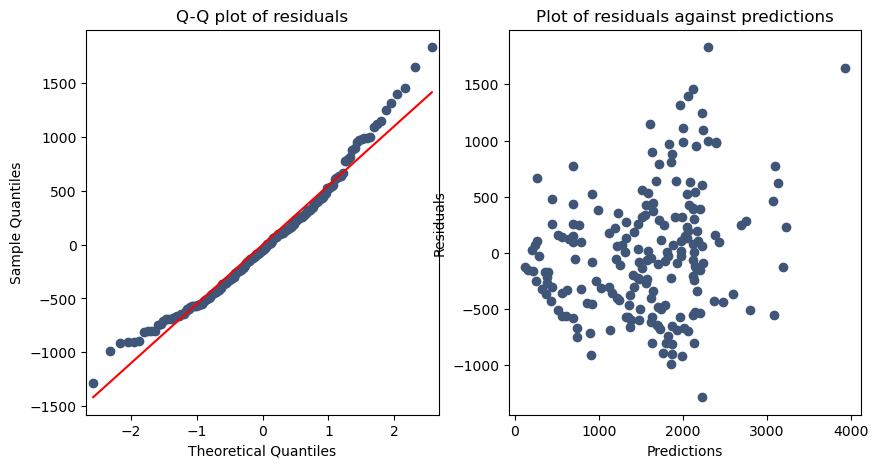

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9734931588172913, pvalue=0.0009052924579009414)
can reject null hypothesis and residuals may not be normally distributed
---------------------------


In [121]:

delta_test_resid=ydelta_test-delta_predictions

homoscedasticity_test(delta_test_resid,delta_predictions)

In [122]:
Results_summary.append(pd.DataFrame({'Model':'Optimised RandomForest',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'no'},index=[0]))

In [ ]:
print(pd.concat(Results_summary).to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |
|  4 | Initial RandomForest Auto Features | Position | 0.649656 |     11.2736 |   2.67684 | yes                |
|  5 | Initial RandomForest Auto Features | LapDelta | 0.681322 | 317470      | 441.067   | no                 |
| 12 | Optimised RandomForest             | LapDelta | 0.696003 | 302845      | 433.692   | no                 |


We can see that the optimised Random Forest for lap time delta has improved the R2, but not MAE. In addittion the optimised model has improved the cluster near to 0 lap time delta but has started to do worse for the high lap time deltas. Under predicting similar to auto feature selection. This may be due to reduce the feature space with hyper parameter tuning.

Next step is to repeat this workflow for Qualifying Position:

## Random Forest Optimise Qualifying Position
<a id="posRF"></a>

First setup the Parameter Grid and complete a wide randomised search

In [128]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(10,500,10),
    'random_forest__criterion':['squared_error', 'absolute_error', 'poisson'],
    'random_forest__max_depth':np.arange(5,100,5),
    'random_forest__min_samples_leaf': np.arange(1,50,5),
    'random_forest__max_features':np.arange(1,70,10),      
    }
   
]

grid_rf = RandomizedSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1, n_iter=100,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'random_forest__n_estimators': 90, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 21, 'random_forest__max_depth': 45, 'random_forest__criterion': 'squared_error'}


In [129]:
print(fittedgrid_rf.best_params_)

{'random_forest__n_estimators': 90, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 21, 'random_forest__max_depth': 45, 'random_forest__criterion': 'squared_error'}


We can see it has selected quite different parameters to the lap time delta. The parameters are much closer to the vanilla model which is expected as that did well straight out of the box. With number of estimators at 100 and max depth at 45. This suggests a much simipler model is needed to predict qualifying position.

We can further refine the parameters with a grid search:

In [136]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(80,101,10),
    'random_forest__criterion':['squared_error'],
    'random_forest__max_depth':np.arange(35,51,5),
    'random_forest__min_samples_leaf': [1],
    'random_forest__max_features':np.arange(15,31,5),    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'random_forest__criterion': 'squared_error', 'random_forest__max_depth': 45, 'random_forest__max_features': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 90}


Save the model:

In [137]:
joblib.dump(fittedgrid_rf.best_estimator_, 'pickled_best_RF_regression_model_position.pkl',compress=('gzip',3))

['pickled_best_RF_regression_model_position.pkl']

In [6]:
RF_best_pos_model = joblib.load('pickled_best_RF_regression_model_position.pkl')

How does this model score compared to the vanilla model:

In [139]:
pos_predictions=RF_best_pos_model.predict(X_test_manual)
print(f'Position Random Forest regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

Position Random Forest regression Initial R2 score with manual selected featuers 0.6544225937178315
Position Random Forest regression Initial MSE score with manual selected feaure 11.12017825648778
Position Random Forest regression Initial MAE score with manual selected feaure 2.6789682539682538


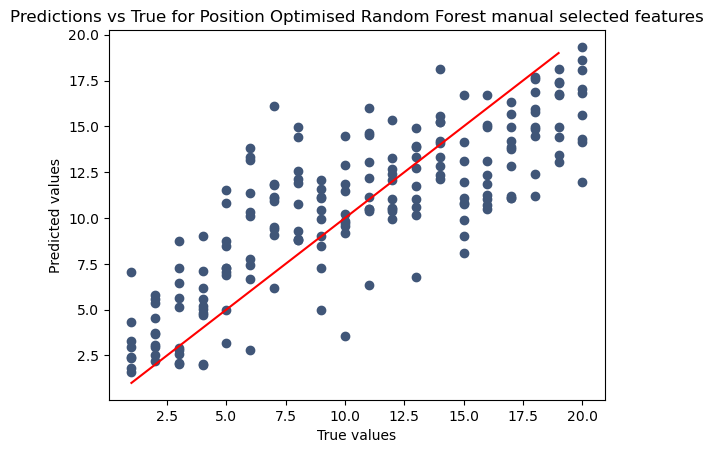

In [140]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Optimised Random Forest manual selected features')
plt.show()

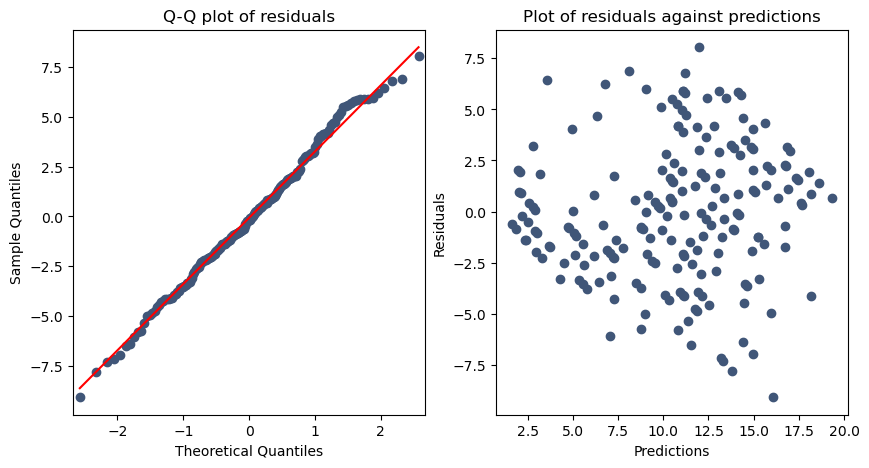

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9936732649803162, pvalue=0.5687599182128906)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


In [141]:
#residuals
pos_test_resid=ypos_test-pos_predictions

homoscedasticity_test(pos_test_resid,pos_predictions)



In [142]:
Results_summary.append(pd.DataFrame({'Model':'Optimised RandomForest',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))


In [ ]:
print(pd.concat(Results_summary).to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |
|  4 | Initial RandomForest Auto Features | Position | 0.649656 |     11.2736 |   2.67684 | yes                |
|  5 | Initial RandomForest Auto Features | LapDelta | 0.681322 | 317470      | 441.067   | no                 |
| 12 | Optimised RandomForest             | LapDelta | 0.696003 | 302845      | 433.692   | no                 |
| 13 | Optimised RandomForest             | Position | 0.654423 |     11.1202 |   2.67897 | yes                |

We can see that actually the R2 for position has not changed much relatively to the vanilla model, however the MAE has increased slightly. Therefore indicating that Random Forest with default parameters is a good as the optimised model. Both models show normally distributed residuals indicating they have captured all the predictive power of the features.

## XGBoost Regressor
<a id="xgintial"></a>

We have seen that ensemble models - Random Forest have improved the results. Random Forest uses multiple trees to minimise the loss or cost function. We can try a boosting technique which fits a baseline model and then uses a series of trees to minimise the residuals. Thereby fitting a series of simple trees to the residuals and not the actual values.

XGBoost is a well known could algorithm for boosting. So we will try to see if XGboost can improve the predictions of Qualifying and Lap time delta

How does the model do with initial default parameters:

In [130]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

xgboost_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('xgboost',XGBRegressor())# classifier
        
]
xgb_pipe=Pipeline(xgboost_estimator)

In [131]:
xgb_pos= xgb_pipe.fit(X_train_manual,ypos_train)
pos_predictions=xgb_pos.predict(X_test_manual)
print(f'Position XGBoost regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position XGBoost regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')
xgb_delta= xgb_pipe.fit(X_train_manual,ydelta_train)
delta_predictions=xgb_delta.predict(X_test_manual)
print(f'Lap Delta XGBoost regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta XGBoost regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Position XGBoost regression Initial R2 score with manual selected featuers 0.6281488815688823
Position XGBoost regression Initial MAE score with manual selected feaure 2.712539847408022
Lap Delta XGBoost regression Initial R2 score with manual selected featuers 0.667719940555014
Lap Delta XGBoost regression Initial MAE score with manual selected feaure 465.4018730241425


We can see that XGBoost has similar results to Random Forest with default parameters. Initially these results look slightly worse than Random Forest. Lets evaluate the results and residuals further:

In [132]:
joblib.dump(xgb_pos,'./pickled_initial_XGB_position_model.pkl')
joblib.dump(xgb_delta,'./pickled_initial_XGB_lap_delta_model.pkl')

['./data/model_data/pickled_initial_XGB_lap_delta_model.pkl']

In [62]:
print(f"Vanilla number of estimators {xgb_pipe['xgboost'].get_params()['n_estimators']}")
print(f"Vanilla depth of trees {xgb_pipe['xgboost'].get_params()['max_depth']}")
print(f"Vanilla learning rate {xgb_pipe['xgboost'].get_params()['learning_rate']}")

Vanilla number of estimators 100
Vanilla depth of trees 6
Vanilla learning rate 0.300000012


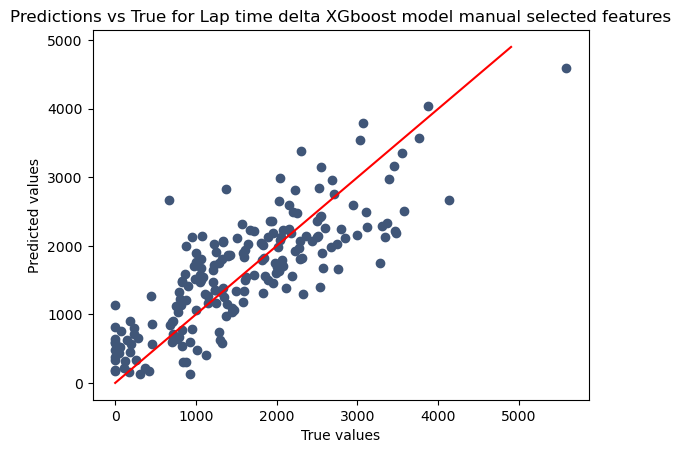

In [63]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta XGboost model manual selected features')
plt.show()

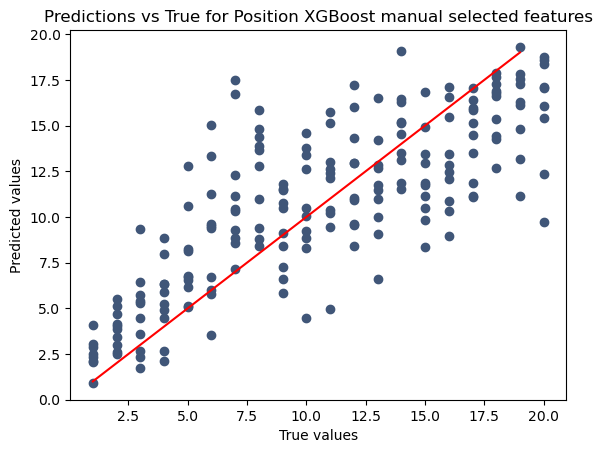

In [64]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position XGBoost manual selected features')
plt.show()

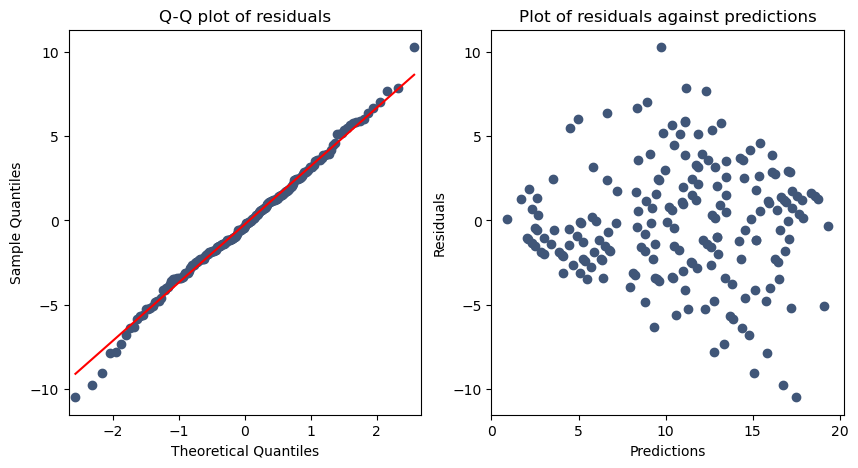

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9956023097038269, pvalue=0.8435552716255188)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


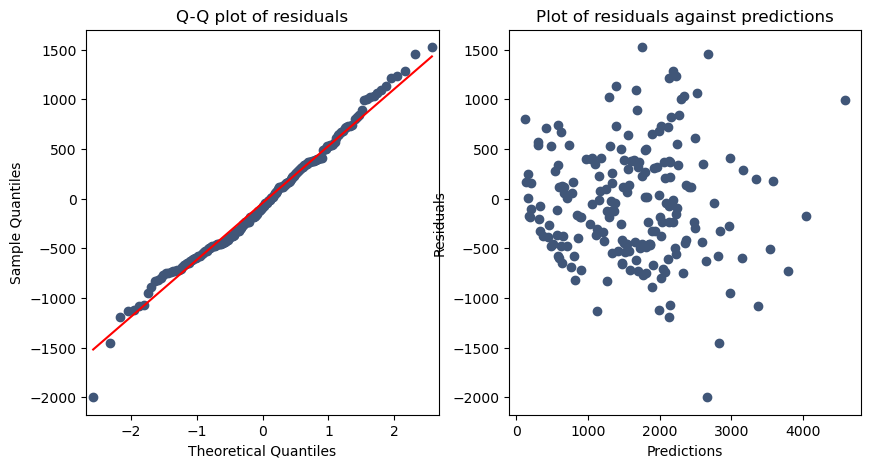

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9895597696304321, pvalue=0.16402079164981842)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


In [65]:
#residuals
pos_test_resid=ypos_test-pos_predictions
delta_test_resid=ydelta_test-delta_predictions
homoscedasticity_test(pos_test_resid,pos_predictions)
homoscedasticity_test(delta_test_resid,delta_predictions)

In [66]:
Results_summary.append(pd.DataFrame({'Model':'Initial XGBoost',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))
Results_summary.append(pd.DataFrame({'Model':'Initial XGBoost',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'yes'},index=[0]))

In [ ]:
print(pd.concat(Results_summary).to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |
|  4 | Initial RandomForest Auto Features | Position | 0.649656 |     11.2736 |   2.67684 | yes                |
|  5 | Initial RandomForest Auto Features | LapDelta | 0.681322 | 317470      | 441.067   | no                 |
| 12 | Optimised RandomForest             | LapDelta | 0.696003 | 302845      | 433.692   | no                 |
| 13 | Optimised RandomForest             | Position | 0.654423 |     11.1202 |   2.67897 | yes                |
|  6 | Initial XGBoost                    | Position | 0.628149 |     11.9656 |   2.71254 | yes                |
|  7 | Initial XGBoost                    | LapDelta | 0.66772  | 331021      | 465.402   | yes                |

We can see that the initial scores of XGBoost for Position and Lap time delta are worse than Random Forest. However when looking at the plots of ytrue versus predictions for lap time delta, we can see that the model has a cluster of points near to the red line of ytrue=predictions and there only a few anomalies that stray away from the main cluster. In addittion the model does better at predicting slow times than RF, and hence the residuals show to be just normally distributed. 

For Qualifying Position compared to Random Forest XGBoost seems to do better for the top drivers and only struggle in the mid fleet pack. This would make sense as these drivers/cars would be expected to show very similar characteristics whereas the top drivers would be expected to stand out.

## Optimised XGboost for laptime delta
<a id="lapdeltaXG"></a>

Similar to Random Forest we can optimise the models using Randomised and Grid search with cross validation. As mentioned above cross validation splits the data into chunks and rotates the train and validation data around these chunks to make sure that the test train split does not cause any basis when picking the optimum hyper parameters.

What is the size of the train and validation set in each fit?:

In [90]:
fold=5
print(f' validation size is {X_train_manual.shape[0]/fold}')
print(f'Train size is {X_train_manual.shape[0] - X_train_manual.shape[0]/fold} ')

 validation size is 339.8
Train size is 1359.2 


In [92]:
param_grid_xg =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(50,200,10),
    'xgboost__learning_rate':[0.1, 0.2, 0.3,0.4,0.5],
    'xgboost__max_depth':np.arange(1,10,2)   
    
    }
   
]

grid_xgb = RandomizedSearchCV(xgb_pipe, param_grid_xg, cv=5,verbose=1, n_iter=200,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb = grid_xgb.fit(X_train_manual, ydelta_train)

print(fittedgrid_xgb.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'xgboost__n_estimators': 90, 'xgboost__max_depth': 9, 'xgboost__learning_rate': 0.1}


In [93]:
param_grid_xgb =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(50,150,10),
    'xgboost__learning_rate':[0.1],
    'xgboost__max_depth':np.arange(5,10,1),

    
    }
   
]

grid_xgb_lap = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5,verbose=1, return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb_lap = grid_xgb_lap.fit(X_train_manual, ydelta_train)

print(fittedgrid_xgb_lap.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__n_estimators': 90}


We can see that the best parameters are not to different the vanilla model, and the trees are short. This could suggest it is a good model as the model looks much simplier than the Random Forest Optimised lap time delta model which had lots of deep trees. 

In [94]:
results_xgb_delta = pd.DataFrame({'Validation score':fittedgrid_xgb_lap.cv_results_['mean_test_score'],
'Train score':fittedgrid_xgb_lap.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_xgb_lap.cv_results_['param_xgboost__n_estimators'],
'learning_rate_in_grid': fittedgrid_xgb_lap.cv_results_['param_xgboost__learning_rate'],
'max_depth_in_grid': fittedgrid_xgb_lap.cv_results_['param_xgboost__max_depth']
})
results_xgb_delta.head()

,Validation score,Train score,n_estimators_in_grid,learning_rate_in_grid,max_depth_in_grid
0,0.404068,0.928455,50,0.1,5
1,0.419052,0.942245,60,0.1,5
2,0.431220,0.950940,70,0.1,5
3,0.436578,0.957632,80,0.1,5
4,0.441234,0.963560,90,0.1,5


In [95]:
# Save the best model
joblib.dump(fittedgrid_xgb_lap.best_estimator_, 'pickled_best_XGboost_regression_model_lap_delta.pkl')

['pickled_best_XGboost_regression_model_lap_delta.pkl']

In [13]:
XG_best_lapdelta_model = joblib.load('pickled_best_XGboost_regression_model_lap_delta.pkl')

In [16]:
delta_predictions=XG_best_lapdelta_model.predict(X_test_manual)
print(f'Lap Delta XGBoost regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta XGBoost  regression Initial MSE score with manual selected feaure {mean_squared_error(ydelta_test,delta_predictions)}')
print(f'Lap Delta XGBoost  regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Lap Delta XGBoost regression Initial R2 score with manual selected featuers 0.6925263569126382
Lap Delta XGBoost  regression Initial MSE score with manual selected feaure 306308.3829948567
Lap Delta XGBoost  regression Initial MAE score with manual selected feaure 439.39621713210124


This optimised XGBoost model has improved from the vanilla model, with R2 increasing to 0.7 and MAE dropping to 439 milliseconds, 0.4s. This suggests that the parameter tuning has improved the model. What do the results look like:

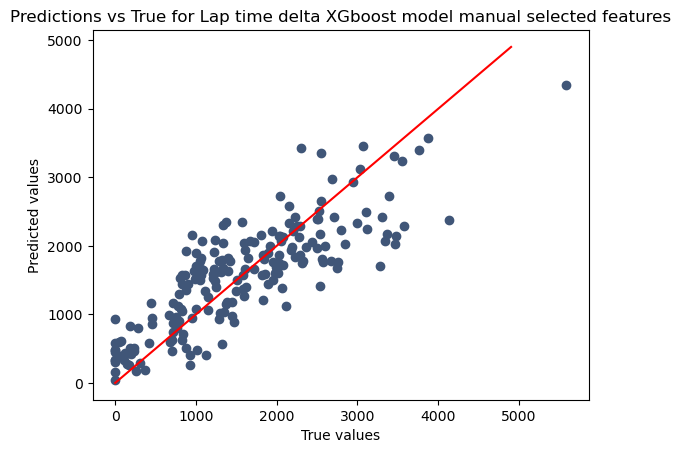

In [98]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta XGboost model manual selected features')
plt.show()

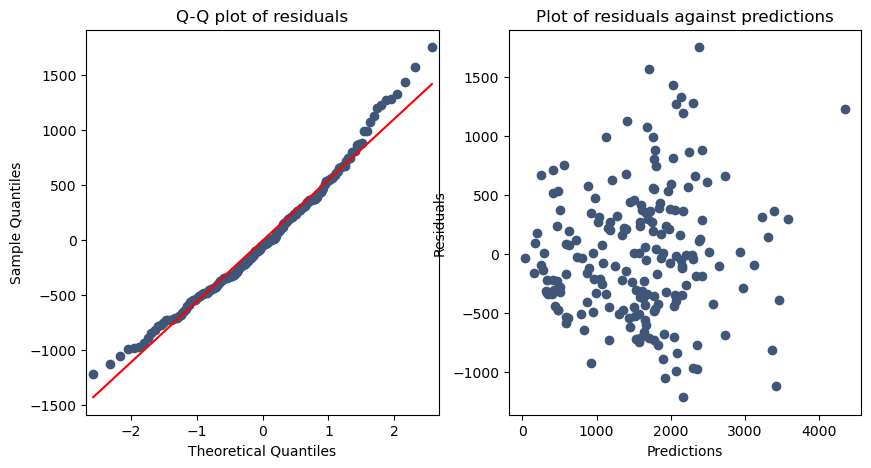

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9814015626907349, pvalue=0.010576349683105946)
can reject null hypothesis and residuals may not be normally distributed
---------------------------


In [99]:

delta_test_resid=ydelta_test-delta_predictions

homoscedasticity_test(delta_test_resid,delta_predictions)

In [100]:
Results_summary.append(pd.DataFrame({'Model':'Optimised XGBoost',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'no'},index=[0]))

In [ ]:
print(pd.concat(Results_summary).to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |
|  4 | Initial RandomForest Auto Features | Position | 0.649656 |     11.2736 |   2.67684 | yes                |
|  5 | Initial RandomForest Auto Features | LapDelta | 0.681322 | 317470      | 441.067   | no                 |
| 12 | Optimised RandomForest             | LapDelta | 0.696003 | 302845      | 433.692   | no                 |
| 13 | Optimised RandomForest             | Position | 0.654423 |     11.1202 |   2.67897 | yes                |
|  6 | Initial XGBoost                    | Position | 0.628149 |     11.9656 |   2.71254 | yes                |
|  7 | Initial XGBoost                    | LapDelta | 0.66772  | 331021      | 465.402   | yes                |
| 10 | Optimised XGBoost                  | LapDelta | 0.692526 | 306308      | 439.396   | no                 |

As discussed above the Optimised XGBoost is a step up in the metrics of R2 and Mean absolute error (MAE). However the residuals are no longer likely normally distributed. Similar to the Random Forest model, during optimisation it starts to under predict the slow drivers lap time deltas, this is focus it does better at predicting the results in the main cluster closer to 0 lap time delta. 

However, it is best model so far as it is similar to the Random Forest model in metrics, but it does better at the higher lap times as it under predicts the results less. 

## Optimise XGBoost for position
<a id="posXG"></a>

Lets run the same workflow for Qualifying Position:

In [101]:
param_grid_xg =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(50,200,10),
    'xgboost__learning_rate':[0.1, 0.2, 0.3,0.4,0.5],
    'xgboost__max_depth':np.arange(1,10,2)   
    }
   
]

grid_xgb_pos = RandomizedSearchCV(xgb_pipe, param_grid_xg, cv=5,verbose=1, n_iter=200,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb_pos = grid_xgb_pos.fit(X_train_manual, ypos_train)

print(fittedgrid_xgb_pos.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'xgboost__n_estimators': 180, 'xgboost__max_depth': 3, 'xgboost__learning_rate': 0.1}


In [102]:
param_grid_xgb =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(100,200,10),
    'xgboost__learning_rate':[0.1],
    'xgboost__max_depth':np.arange(1,6,1),

    
    }
   
]

grid_xgb_pos = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5,verbose=1, return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb_pos = grid_xgb_pos.fit(X_train_manual, ypos_train)

print(fittedgrid_xgb_pos.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 180}


Different to Lap time delta it has done best with more shorter trees.

In [103]:
results_xgb_pos = pd.DataFrame({'Validation score':fittedgrid_xgb_pos.cv_results_['mean_test_score'],
'Train score':fittedgrid_xgb_pos.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_xgb_pos.cv_results_['param_xgboost__n_estimators'],
'learning_rate_in_grid': fittedgrid_xgb_pos.cv_results_['param_xgboost__learning_rate'],
'max_depth_in_grid': fittedgrid_xgb_pos.cv_results_['param_xgboost__max_depth']
})
results_xgb_delta.head()

,Validation score,Train score,n_estimators_in_grid,learning_rate_in_grid,max_depth_in_grid
0,0.404068,0.928455,50,0.1,5
1,0.419052,0.942245,60,0.1,5
2,0.431220,0.950940,70,0.1,5
3,0.436578,0.957632,80,0.1,5
4,0.441234,0.963560,90,0.1,5


In [104]:
# Save the best model
joblib.dump(fittedgrid_xgb_pos.best_estimator_, 'pickled_best_XGboost_regression_model_position.pkl')

['pickled_best_XGboost_regression_model_position.pkl']

In [17]:
XG_best_position_model = joblib.load('pickled_best_XGboost_regression_model_position.pkl')

In [106]:
pos_predictions=XG_best_position_model.predict(X_test_manual)
print(f'Position XGBoost regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position XGBoost regression Initial MSE score with manual selected feaure {mean_squared_error(ypos_test,pos_predictions)}')
print(f'Position XGBoost regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

Position XGBoost regression Initial R2 score with manual selected featuers 0.6398723396822839
Position XGBoost regression Initial MSE score with manual selected feaure 11.58838426651946
Position XGBoost regression Initial MAE score with manual selected feaure 2.7883043696685714


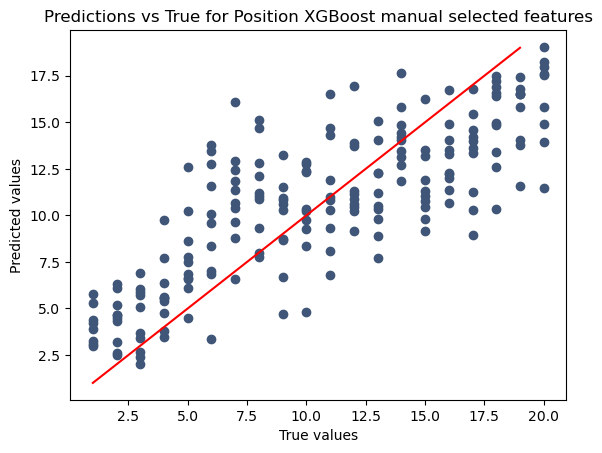

In [107]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position XGBoost manual selected features')
plt.show()

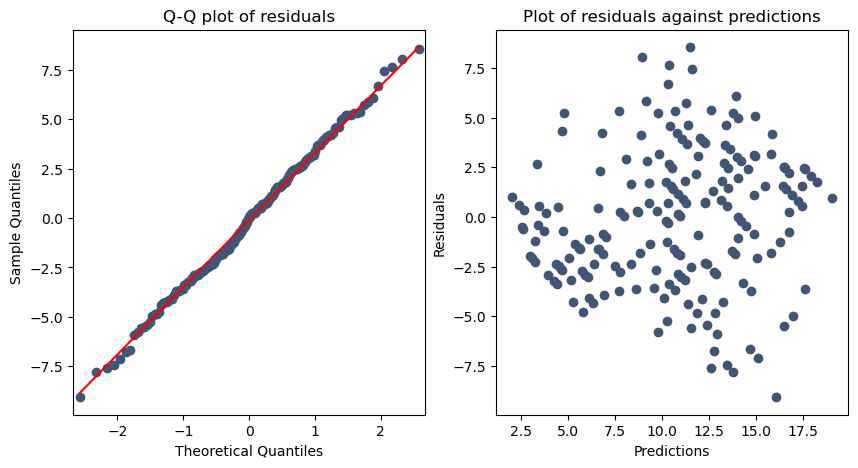

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9958711266517639, pvalue=0.8757799863815308)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


In [108]:
#residuals
pos_test_resid=ypos_test-pos_predictions

homoscedasticity_test(pos_test_resid,pos_predictions)


In [109]:
Results_summary.append(pd.DataFrame({'Model':'Optmised XGBoost',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))


In [ ]:
print(pd.concat(Results_summary).to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |
|  4 | Initial RandomForest Auto Features | Position | 0.649656 |     11.2736 |   2.67684 | yes                |
|  5 | Initial RandomForest Auto Features | LapDelta | 0.681322 | 317470      | 441.067   | no                 |
| 12 | Optimised RandomForest             | LapDelta | 0.696003 | 302845      | 433.692   | no                 |
| 13 | Optimised RandomForest             | Position | 0.654423 |     11.1202 |   2.67897 | yes                |
|  6 | Initial XGBoost                    | Position | 0.628149 |     11.9656 |   2.71254 | yes                |
|  7 | Initial XGBoost                    | LapDelta | 0.66772  | 331021      | 465.402   | yes                |
| 10 | Optimised XGBoost                  | LapDelta | 0.692526 | 306308      | 439.396   | no                 |
| 11 | Optmised XGBoost                   | Position | 0.639872 |     11.5884 |   2.7883  | yes                |

We can see that the optimised XGBoost has improved however the results are worse than the Optimised Random forest Therefore the Random Forest is the best model for qualifying position so far

## Simple Neural Network
<a id="nn"></a>

We have tried some complex ensemble methods and got reasonable results for regression. The last idea to test is a more complex model ensemble model which is a Neural Network. A Neural Network can be though of a ensemble of Linear models with a activation functions, assembled into a series of layers.

A Neural Network does not have a the option to do cross validation easily. Therefore to test the best parameters we will do a manual test train split to test multiple architectures. 

In [68]:
X_train_manual_split, X_val_manual, ydelta_train_split, ydelta_val = train_test_split(X_train_manual,ydelta_train,test_size=0.2,random_state=123)

As we have done before we have done column transformation in a pipeline. to do this with a Keras sequential Neural network we need to creat a function which we can call in the pipeline.

In [69]:
def create_model():
    # Create a new sequential model
    model = keras.Sequential()

    regularizer = keras.regularizers.l2(0.01)

    # Declare the hidden layers
    
    model.add(Dense(100, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation="relu", kernel_regularizer=regularizer))
    
    # Declare the output layer
    model.add(Dense(1)) # For regression, we don't specify any activation function.

    # Compile the model
    model.compile(
        # Optimizer
        optimizer=keras.optimizers.Adam(),  
        # Loss function to minimize
        loss=keras.losses.MeanAbsoluteError()
    )
    return model

The best simple neural network which was tuned was an input layer of 74 features (manual selection) into 3 dense layers of 100 nodes. Which taper down to 50 and 25.  Then a final dense node of 1 to give the regression output. All layers have drop out to regularise and stop the model over fitting. 

Multiple model archietectures were tested, simple models with only one or two layers and more complex. This was found to be the most optimal archietecture in the time available. 

The Model loss to monitor is Mean Absolute Error, this is because this error likely matters more to Teams and drivers than the R2. They would like to know the error of the model, how accurate in milliseconds is the prediction for example. Therefore we want to reduce this as much as possible.

The network will use the Adam optimiser which is the typical default in the industry.

In [81]:
# set stopping criteria
callbacks = EarlyStopping(monitor='loss', min_delta=0.05, patience=10)
clf = KerasRegressor(build_fn=create_model,epochs=400, verbose=0,callbacks=[callbacks])

We will call the early stopping call back, as this allows us to train the model for lots of epochs and it will automatically stop when it the loss value stops improving. 
We use the Sklearn wrapper KerasRegressor to make an neural network object that can be put into the pipeline

In [84]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

nueral_network_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('nueral_network',clf)# classifier
        
]
nn_pipe=Pipeline(nueral_network_estimator)

To get the history object out to plot the learning and reduction in validation and train, we need to run the steps invidually, not in the pipeline. Therefore, fit and transform the X train columns and just transform the validation columns

In [72]:
X_train_manual_split_array=nn_pipe['column_transform'].fit_transform(X_train_manual_split)
X_val_manual_array=nn_pipe['column_transform'].transform(X_val_manual)

Then we can train the model:

In [73]:
history=nn_pipe['nueral_network'].fit(X_train_manual_split_array,ydelta_train_split.values, validation_data=(X_val_manual_array,ydelta_val.values))

Lets plot the Validation and Train loss over the epochs:

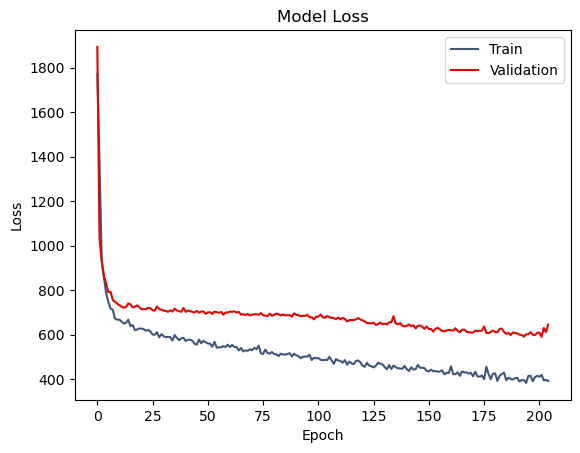

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

We can see that initially the model rapidly learns the loss for Lap time delta rapidly improves, then from Epoch 15 to 200 it improves at a slower rate. The Validation score starts to get worse and hence the model stops training before it starts to over fit.

We we have tested the archiecture, lets run a fit and prediction for the whole Train set and test on the test set:

## Neural Network Lap time delta predictions
<a id="lapdeltann"></a>

In [75]:
#fit to the whole test set
history = nn_pipe.fit(X_train_manual,ydelta_train)

In [76]:
# Predict
delta_predictions=history.predict(X_test_manual)
print(f'Lap Delta Neural Network regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Neural Network regression Initial MSE score with manual selected feaure {mean_squared_error(ydelta_test,delta_predictions)}')
print(f'Lap Delta Neural Network regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Lap Delta Neural Network regression Initial R2 score with manual selected featuers 0.6417116124674791
Lap Delta Neural Network regression Initial MSE score with manual selected feaure 356930.5503032627
Lap Delta Neural Network regression Initial MAE score with manual selected feaure 451.6957316495934


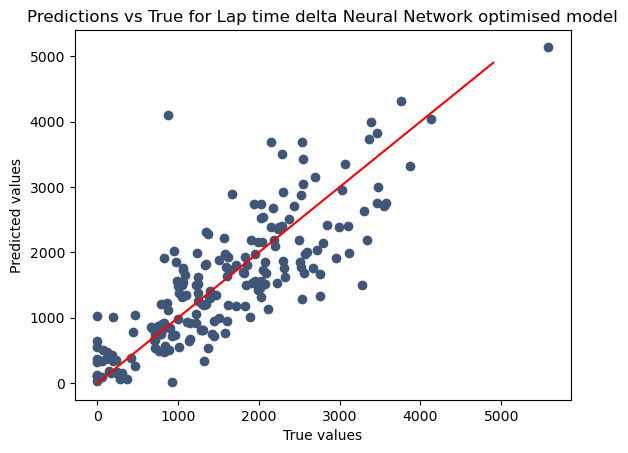

In [77]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Neural Network optimised model')
plt.show()

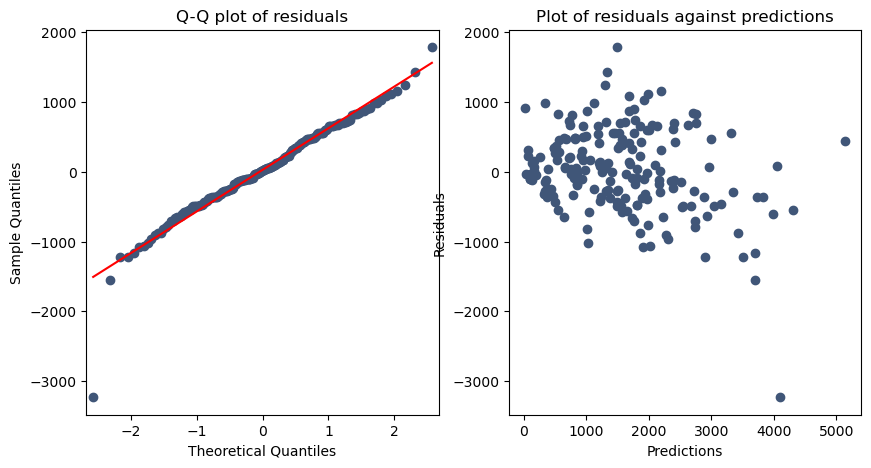

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.9612656831741333, pvalue=3.282343823229894e-05)
can reject null hypothesis and residuals may not be normally distributed
---------------------------


In [78]:

delta_test_resid=ydelta_test-delta_predictions

homoscedasticity_test(delta_test_resid,delta_predictions)

In [79]:
Results_summary.append(pd.DataFrame({'Model':'Neural Network',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions),
'homoscedasticity':'no'},index=[0]))

In [ ]:
print(pd.concat(Results_summary).to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |
|  4 | Initial RandomForest Auto Features | Position | 0.649656 |     11.2736 |   2.67684 | yes                |
|  5 | Initial RandomForest Auto Features | LapDelta | 0.681322 | 317470      | 441.067   | no                 |
| 12 | Optimised RandomForest             | LapDelta | 0.696003 | 302845      | 433.692   | no                 |
| 13 | Optimised RandomForest             | Position | 0.654423 |     11.1202 |   2.67897 | yes                |
|  6 | Initial XGBoost                    | Position | 0.628149 |     11.9656 |   2.71254 | yes                |
|  7 | Initial XGBoost                    | LapDelta | 0.66772  | 331021      | 465.402   | yes                |
| 10 | Optimised XGBoost                  | LapDelta | 0.692526 | 306308      | 439.396   | no                 |
| 11 | Optmised XGBoost                   | Position | 0.639872 |     11.5884 |   2.7883  | yes                |
|  8 | Neural Network                     | LapDelta | 0.641712 | 356931      | 451.696   | no                 |

We can see the a simple neural network has not improve the prediction of lap time delta. The metrics are worse than the optimised XGBoost. The residuals look normally distributed on a q-q plot. However there are large anomalies, plus the error looks to widen at larger lap time deltas compared to smaller ones. This may indicate there is still a pattern in the residuals. 

The optimised XG boost is still considered the best model for Lap time delta.

## Neural Network Position
<a id="posnn"></a>

Lets repeat the predictions with a Neural Network for Qualifying Position.

First we have to re initiatlise the Neural Network:

In [82]:
# set stopping criteria
callbacks = EarlyStopping(monitor='loss', min_delta=0.05, patience=10)
clf = KerasRegressor(build_fn=create_model,epochs=400, verbose=0,callbacks=[callbacks])

In [ ]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

nueral_network_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('nueral_network',clf)# classifier
        
]
nn_pipe=Pipeline(nueral_network_estimator)

In [85]:
history = nn_pipe.fit(X_train_manual,ypos_train)
pos_predictions=history.predict(X_test_manual)
print(f'Position Neural Network regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Neural Network regression Initial MSE score with manual selected feaure {mean_squared_error(ypos_test,pos_predictions)}')
print(f'Position Neural Network regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

Position Neural Network regression Initial R2 score with manual selected featuers 0.6200443982924703
Position Neural Network regression Initial MSE score with manual selected feaure 12.22641857867552
Position Neural Network regression Initial MAE score with manual selected feaure 2.7221221279124825


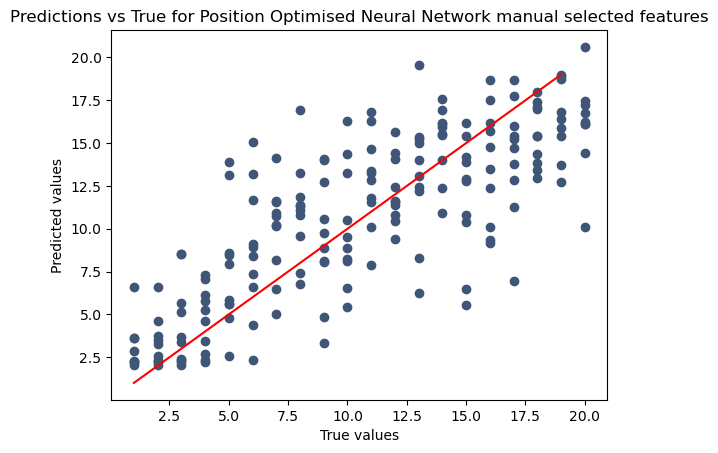

In [86]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Optimised Neural Network manual selected features')
plt.show()

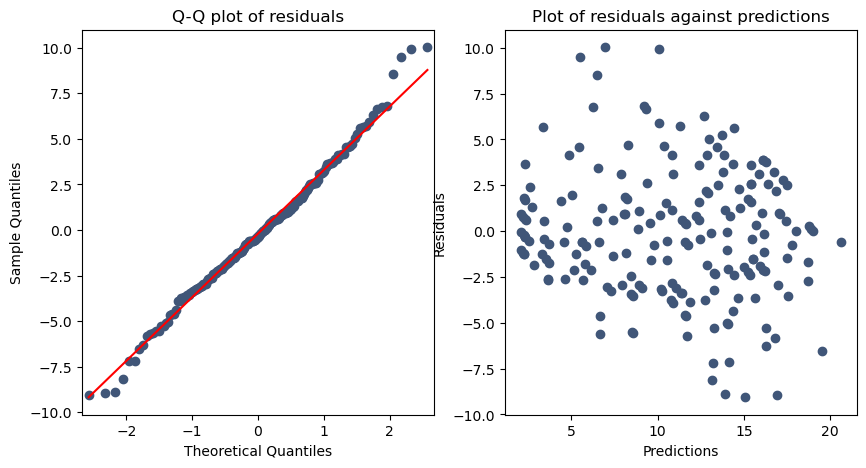

Shaprio-Wilk test of Residuals is: 
  ShapiroResult(statistic=0.991827666759491, pvalue=0.33902326226234436)
can not reject null hypothesis and the residuals are likely normally distributed
---------------------------


In [88]:

pos_test_resid=ypos_test-pos_predictions

homoscedasticity_test(pos_test_resid,pos_predictions)

In [89]:
Results_summary.append(pd.DataFrame({'Model':'Neural Network',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions),
'homoscedasticity':'yes'},index=[0]))

In [ ]:
print(pd.concat(Results_summary).to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |
|  4 | Initial RandomForest Auto Features | Position | 0.649656 |     11.2736 |   2.67684 | yes                |
|  5 | Initial RandomForest Auto Features | LapDelta | 0.681322 | 317470      | 441.067   | no                 |
| 12 | Optimised RandomForest             | LapDelta | 0.696003 | 302845      | 433.692   | no                 |
| 13 | Optimised RandomForest             | Position | 0.654423 |     11.1202 |   2.67897 | yes                |
|  6 | Initial XGBoost                    | Position | 0.628149 |     11.9656 |   2.71254 | yes                |
|  7 | Initial XGBoost                    | LapDelta | 0.66772  | 331021      | 465.402   | yes                |
| 10 | Optimised XGBoost                  | LapDelta | 0.692526 | 306308      | 439.396   | no                 |
| 11 | Optmised XGBoost                   | Position | 0.639872 |     11.5884 |   2.7883  | yes                |
|  8 | Neural Network                     | LapDelta | 0.641712 | 356931      | 451.696   | no                 |
|  9 | Neural Network                     | Position | 0.620044 |     12.2264 |   2.72212 | yes                |

We can see the Neural Network for position has not improved on the optimised Random Forest model for prediction. Therefore the Random Forest optimised model for Position is still considered the best.

## Summary
<a id="summary"></a>

Summary of the regression model results for both Qualifying Position and Lap Time Delta

In [143]:
Regression_model_summary = pd.concat(Results_summary)

In [144]:
Regression_model_summary.reset_index(drop=True,inplace=True)

In [ ]:
#save the summary
Regression_model_summary.to_pickle('./data/model_data/regression_model_summary.pkl',compression='gzip')

In [2]:
Regression_model_summary = pd.read_pickle('./data/model_data/regression_model_summary.pkl',compression='gzip')

In [7]:
#split the summary into Position and Lap time delta
Position_summary = Regression_model_summary[Regression_model_summary['Target'] == 'Position']
Lapdelta_summary = Regression_model_summary[Regression_model_summary['Target'] == 'LapDelta']

### Summary plot for Qualifying Position

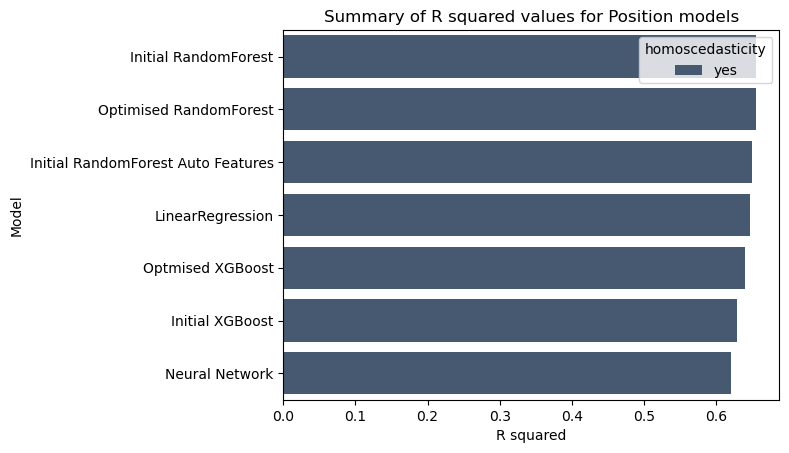

In [9]:
Position_summary.sort_values(by='R2',ascending=False,inplace=True)
sns.barplot(Position_summary,y='Model',x='R2',hue='homoscedasticity')
plt.title('Summary of R squared values for Position models')
plt.xlabel('R squared')
plt.show()


This bar plot clearly shows that Random Forest is the best model for Qualifying position predictions based on R2. ALso all the models were able to capture all the patterns in the data and there were no patterns left in the residuals. 

The Random Forest model, likely did best as there are likely a number of simple linear relationships between features like speed and time on brakes with results. Plus the hot encoded variables of driver and team likely have a semi linear relationship. Therefore lots of simple trees should be able to capture this well.

### Summary plot for Lap time delta

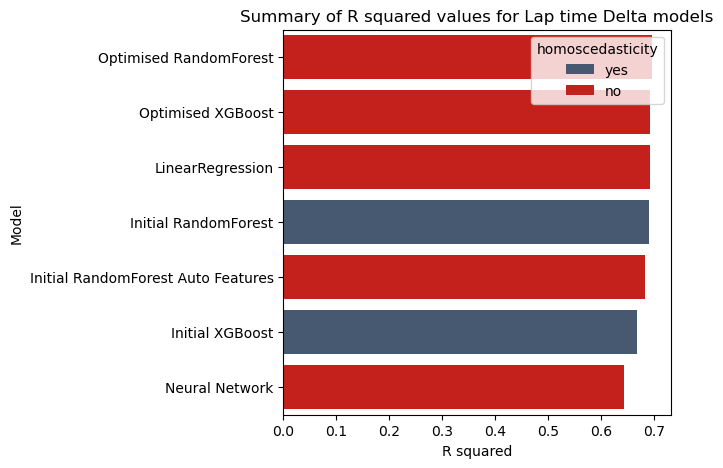

In [19]:
Lapdelta_summary.sort_values(by='R2',ascending=False,inplace=True)
plt.figure(figsize=(5,5))
sns.barplot(Lapdelta_summary,y='Model',x='R2',hue='homoscedasticity',hue_order=['yes','no'],dodge=False)

plt.title('Summary of R squared values for Lap time Delta models')
plt.xlabel('R squared')
plt.show()

There is a lot of models which struggle to capture all the patterns in the data, with the residuals still being not normally distributed for most of the models. This highlights the complexity of trying to predict Lap time delta.

Lap time delta has a lot more variables and is likely more complex than Qualifying Position. This is because it will be affected by the circuit characteristics as well as the driver performance

Even though Random Forest got the highest R2, XGBoost will be selected as the best model, this is because it did better at the higher lap time deltas. It had a better dsitribution of residuals and under predicted the results at high lap time less poorly than Random Forest did.

In [26]:
print(Regression_model_summary.to_markdown())

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |
|  4 | Initial RandomForest Auto Features | Position | 0.649656 |     11.2736 |   2.67684 | yes                |
|  5 | Initial RandomForest Auto Features | LapDelta | 0.681322 | 317470      | 441.067   | no                 |
|  6 | Initial XGBoost                    | Position | 0.628149 |     11.9656 |   2.71254 | yes 

Summary Table:

|    | Model                              | Target   |       R2 |         MSE |       MAE | homoscedasticity   |
|---:|:-----------------------------------|:---------|---------:|------------:|----------:|:-------------------|
|  0 | LinearRegression                   | Position | 0.646671 |     11.3696 |   2.65643 | yes                |
|  1 | LinearRegression                   | LapDelta | 0.691183 | 307647      | 438.213   | no                 |
|  2 | Initial RandomForest               | Position | 0.654465 |     11.1188 |   2.64566 | yes                |
|  3 | Initial RandomForest               | LapDelta | 0.689061 | 309761      | 433.313   | yes                |
|  4 | Initial RandomForest Auto Features | Position | 0.649656 |     11.2736 |   2.67684 | yes                |
|  5 | Initial RandomForest Auto Features | LapDelta | 0.681322 | 317470      | 441.067   | no                 |
|  6 | Initial XGBoost                    | Position | 0.628149 |     11.9656 |   2.71254 | yes                |
|  7 | Initial XGBoost                    | LapDelta | 0.66772  | 331021      | 465.402   | yes                |
|  8 | Neural Network                     | LapDelta | 0.641712 | 356931      | 451.696   | no                 |
|  9 | Neural Network                     | Position | 0.620044 |     12.2264 |   2.72212 | yes                |
| 10 | Optimised XGBoost                  | LapDelta | 0.692526 | 306308      | 439.396   | no                 |
| 11 | Optmised XGBoost                   | Position | 0.639872 |     11.5884 |   2.7883  | yes                |
| 12 | Optimised RandomForest             | LapDelta | 0.696003 | 302845      | 433.692   | no                 |
| 13 | Optimised RandomForest             | Position | 0.654423 |     11.1202 |   2.67897 | yes                |

## Feature Importance - Position Prediction
<a id="feature"></a>

When evaluating the models, even though the scores on face value are not that got at 0.7 R2. The models have likely learnt something about the data which could be insightful to Drivers, Teams and Fans. What are the most important features in predicting Qualifying Position?

The best Qualifying Position Model is the Optimised Random Forest. We need to extract the features and feature names. By Applying the column transform step to get the feature names.

We will compare the Shaply Algorithm of feature importance with Random Forest Feature importance calcuation:

In [ ]:
features = RF_best_pos_model.named_steps['column_transform'].transform(X_train_manual)
feature_names = RF_best_pos_model.named_steps['column_transform'].get_feature_names_out()

In [8]:
explainer = shap.TreeExplainer(RF_best_pos_model.named_steps['random_forest'])

# Obtain SHAP values 
shap_values = explainer.shap_values(features)

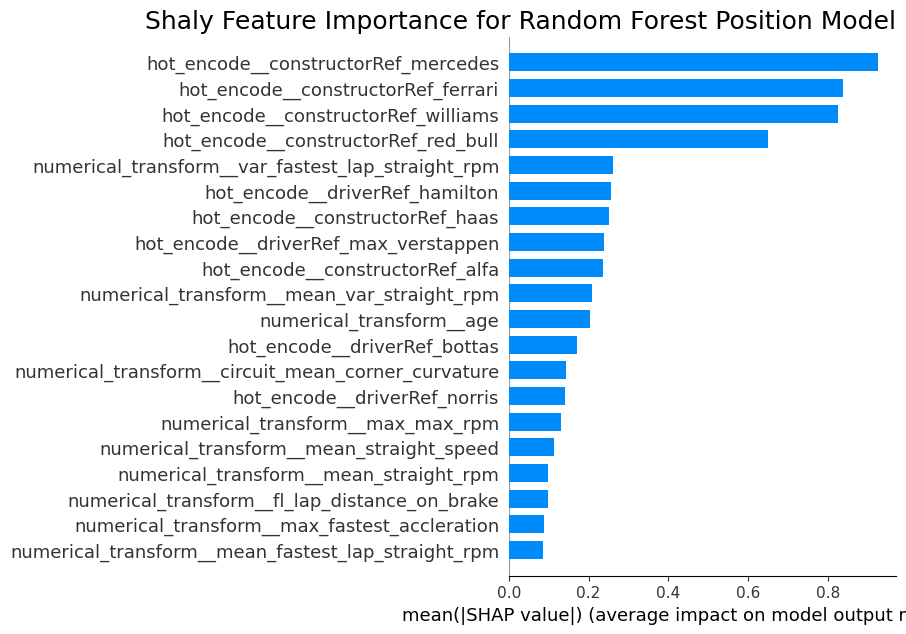

In [23]:
# Global interpretation - summary plot - type = 'dot'
shap.initjs()
plt.title('Shaply Feature Importance for Random Forest Position Model',fontsize=18,loc='right')
shap.summary_plot(shap_values, features=features, feature_names=list(feature_names),plot_type='bar',plot_size=(5,7))

plt.show()

The Random Forest model has found that the top and bottom teams are a very good predictor. Mercedes, Ferrai and Red Bull are the top teams and are very consistent. Williams has generally done poorly in the last few years. Therefore it seems the model has learnt that,and found that these teams are a good predictor of results. 

There is a next tier of features which have a much less impact, these are made up of some of the top drivers and other poor teams. However there are also interesting features the model is learning That the variance of the enginer revolution per minute on the straight is a good predictor. 

This was not expected and would intersting to investigate further with more domain knowledge. Maybe this is because engines which are performing better and can quickly get up to their maximum RPM. Whereas worse engines take longer to get up to max RPM and show more variability. 

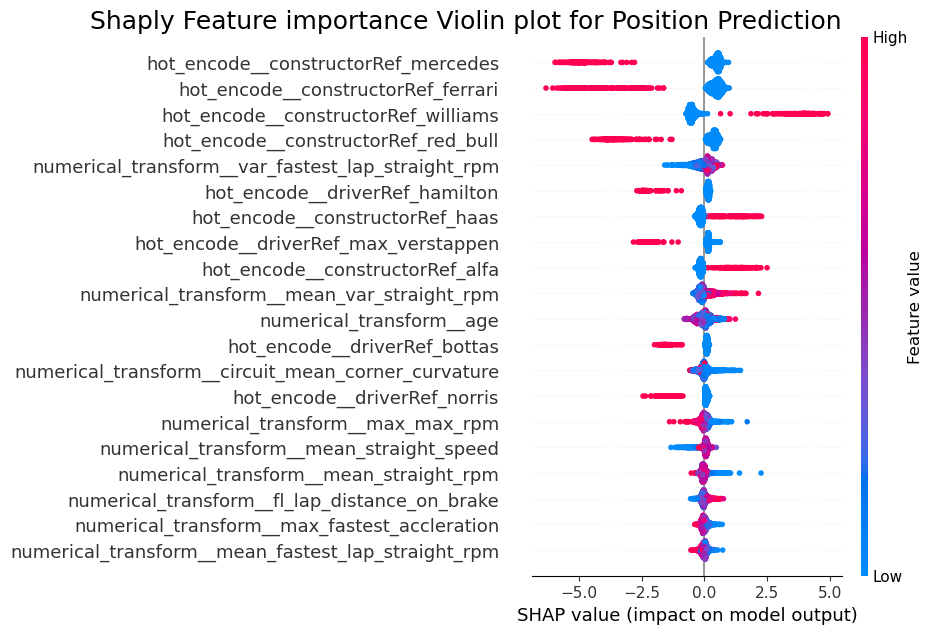

In [24]:
plt.title('Shaply Feature importance Violin plot for Position Prediction',fontsize=18,loc='right')
shap.summary_plot(shap_values, features=features, feature_names=list(feature_names),plot_size=(5,7))
plt.show()

When looking at the violin plot of feature importance we can see that the top teams of Mercedes, Ferrari and Red Bull when they are 1 i.e. the car is one those teams, the model predicts a lower position as expected. For RPM a higher variance in RPM predicts a worse position as described above this may indicate the performance of the engine. Whereas an engine that gets up to hihger RPM is likely to perform better as shown by the feature max_max_rpm.

The shaply values of feature importance can be compared to the Random Forest feature importance:

In [11]:
RF_results = pd.DataFrame(data=RF_best_pos_model['random_forest'].feature_importances_ ,index=RF_best_pos_model['column_transform'].get_feature_names_out())
RF_results.rename(columns={0:'Random_forest_result'},inplace=True)

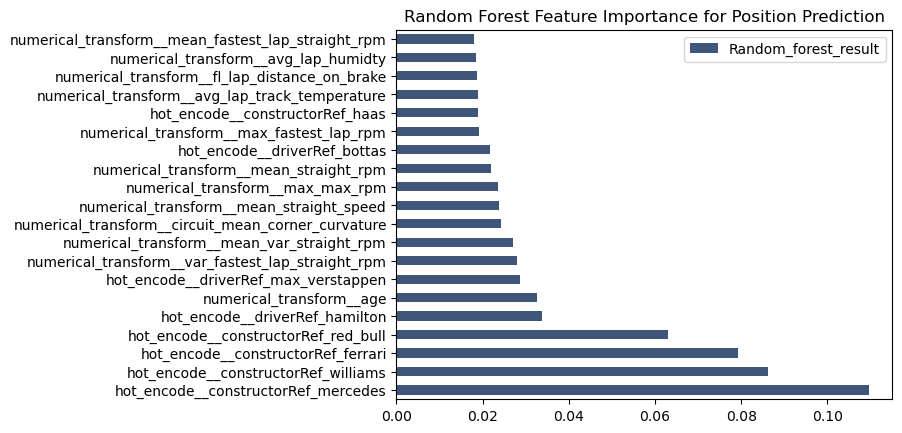

In [25]:
RF_results.sort_values(by='Random_forest_result',ascending=False).head(20).plot(kind='barh')
plt.title('Random Forest Feature Importance for Position Prediction')
plt.show()

Random forest feature importnace shows very similar outputs to Shaply for Qualifying positon.

## Feature Importance - Lap time delta prediction

How about Lap time delta, what hs the model learnt about predicting Lap time delta?

In [27]:
features_xg= XG_best_lapdelta_model.named_steps['column_transform'].transform(X_train_manual)
feature_names_xg = XG_best_lapdelta_model.named_steps['column_transform'].get_feature_names_out()

In [31]:
XG_results = pd.DataFrame(data=XG_best_lapdelta_model['xgboost'].feature_importances_ ,index=XG_best_lapdelta_model['column_transform'].get_feature_names_out())
XG_results.rename(columns={0:'XGboost_result'},inplace=True)

### XGboost feature importance

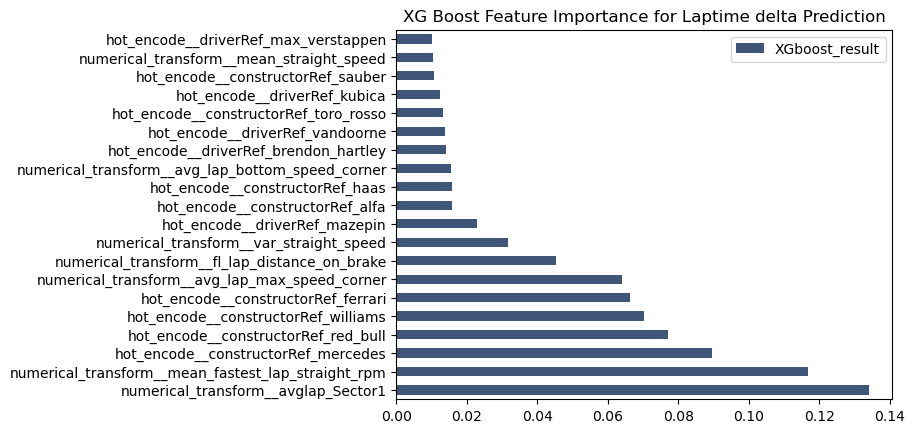

In [32]:
XG_results.sort_values(by='XGboost_result',ascending=False).head(20).plot(kind='barh')
plt.title('XG Boost Feature Importance for Laptime delta Prediction')
plt.show()

The XGBoost model to predict lap time delta has put importance on different features than Qualifying Position. It has used the average lap 1 sector time as a key indictor, the variance in fastest lap RPM. Both of these features above the top teams. Then interesting features suchs as:
- average lap max speed in the corner
- Fastest lap distance spent on the brakes
- Variance in staight line speed

This prediction has use many more features from the telemetry data, showing that to predcit the lap time a driver is behind the pole time, these features are more useful. Of the the telemetry features it is interesting it has selected these features. These would have to be investigated further with experts of Formula1.

### Shaply feature importance for XGBoost

Does Shaply algorithm aggree?

In [28]:
explainer = shap.TreeExplainer(XG_best_lapdelta_model.named_steps['xgboost'])

# Obtain SHAP values 
shap_values = explainer.shap_values(features_xg)

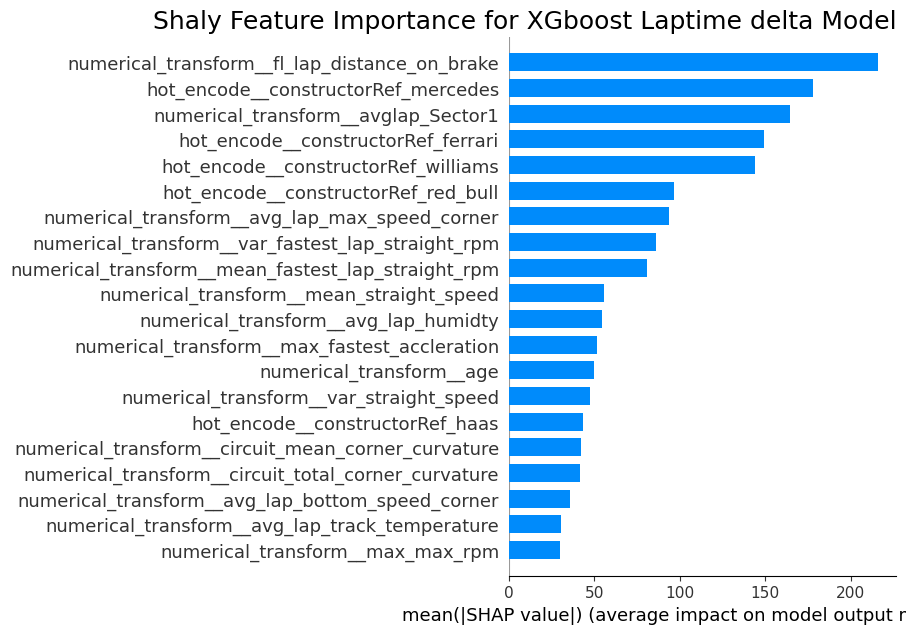

In [29]:
# Global interpretation - summary plot - type = 'dot'
shap.initjs()
plt.title('Shaly Feature Importance for XGboost Laptime delta Model',fontsize=18,loc='right')
shap.summary_plot(shap_values, features=features_xg, feature_names=list(feature_names_xg),plot_type='bar',plot_size=(5,7))

plt.show()

Overal the shaply algorithm agrees with XGBoost feature importance. However, the top feature is flying lap distance on brakes, ahead of the first sector time. 

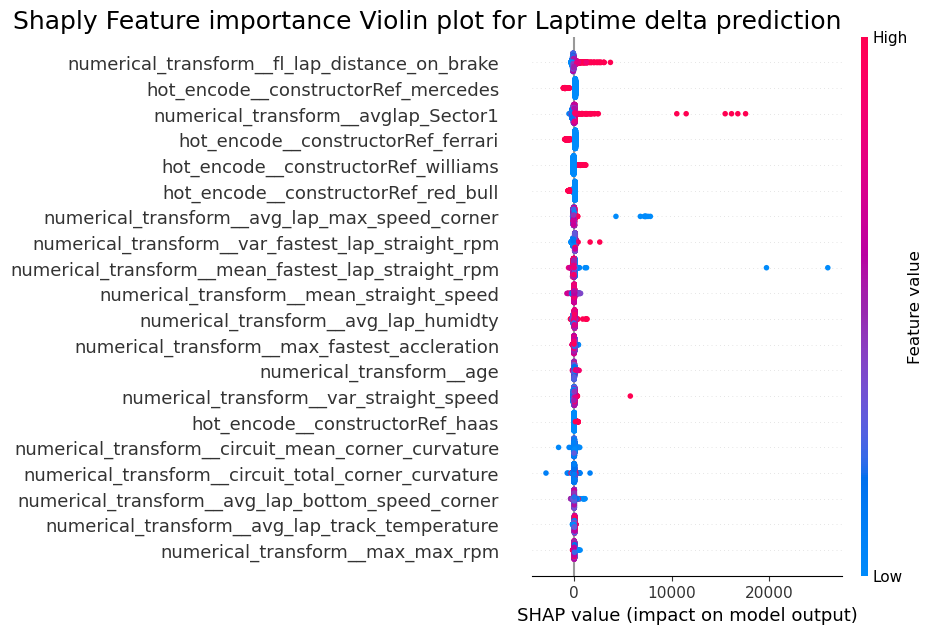

In [30]:
plt.title('Shaply Feature importance Violin plot for Laptime delta prediction',fontsize=18,loc='right')
shap.summary_plot(shap_values, features=features_xg, feature_names=list(feature_names_xg),plot_size=(5,7))
plt.show()

The Shaply violin plot shows how the prediction of lap time delta, struggles with larger lap time deltas and for certain cricuits where the features are very different ot the other circuits.

It shows that large values in Sector 1 cause high values of lap time delta. What happens when a circuit has a longer sector 1, or the circuit is longer in general. This possible explains why the model can struggle for certain Grand Prix's. This will be explored further in the next notebook on the evaluation of the model over 2022 [9_Formula1_predicting_last_races_2022_season](./9_Formula1_predicting_last_races_2022_season.ipynb). In addition anomalous low values of Straight RPM also cause high lap time deltas, this is more expected as if the engine is performing poorly, the results is expected to be worse. Similar for the max speed in the corner, slower cornering speed causes high lap time delta, which is expected. 

It can be observed that the variance in some of these critical features can be liked to the large lap time deltas. If the variance comes from the driver and car performance it could be a good predictor, if it is more related to the circuit it could be a poor predictor. This topic will be evaluated further in the next notebook.

## Summary
<a id="summary2"></a>

Is this notebook we have:

- Built a range of regression models to predict the results for Qualifying Position and Lap Time Delta:
    - Linear Regression
    - Random Forest
    - XG Boost
    - Neural Network
- Optimised the hyper parameters for Random Forest and XGBoost
- Evaluated the performance of the models and selected the best models:
    - Random Forest for Qualifying Position
    - XGBoost for Lap Time Delta
- Evaluated the importance features for each prediction and found:
    - Position prediction is heavily linked to the top teams, with some interesting features in variance of RPM of the engine
    - Lap time delta uses more features related to the car telemetry, and is affected by distance on brakes, sector times, cornering speed and RPM of the engine.

## Next Steps
<a id="nextsteps"></a>

The next steps is to download the data for the qualifying sessions that have occured between when this project started in September 2022 and present day November 2022. Then evaluate the model predictive power on these races, a fresh test set to mimic the real world.